In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import keras.layers

In [2]:
train_dir = Path('shapes/Train')
train_filepaths = list(train_dir.glob(r'**/*.png'))

test_dir = Path('shapes/Test')
test_filepaths = list(test_dir.glob(r'**/*.png'))

val_dir = Path('shapes/validation')
val_filepaths = list(test_dir.glob(r'**/*.png'))

In [3]:
[str(train_filepaths[i]).split("/")[-2] \
for i in range(len(train_filepaths))]

IndexError: list index out of range

In [5]:
a=str(train_filepaths[0])
b=a.split("\\")
b[2]

'circles'

In [6]:
def proc_img(filepath):
    """ Create a DataFrame with the filepath and the labels of the pictures
    """

    labels = [str(filepath[i]).split("\\")[2] \
              for i in range(len(filepath))]

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')

    # Concatenate filepaths and labels
    df = pd.concat([filepath, labels], axis=1)

    # Shuffle the DataFrame and reset index
    df = df.sample(frac=1).reset_index(drop = True)
    
    return df

train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)


In [7]:
print('-- Training set --\n')
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels: {train_df.Label.unique()}')

-- Training set --

Number of pictures: 150

Number of different labels: 3

Labels: ['squares' 'circles' 'triangles']


In [8]:
train_df.head(5)

,Filepath,Label
0,shapes\Train\squares\drawing(52).png,squares
1,shapes\Train\circles\drawing(95).png,circles
2,shapes\Train\squares\drawing(88).png,squares
3,shapes\Train\circles\drawing(60).png,circles
4,shapes\Train\triangles\drawing(53).png,triangles


In [9]:
df_unique

NameError: name 'df_unique' is not defined

In [10]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(28, 28),
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 150 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.
Found 150 validated image filenames belonging to 3 classes.


In [11]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(32, 32, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [12]:
#inputs = pretrained_model.input
 
#x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
#x = tf.keras.layers.Dense(128, activation='relu')(x)

#outputs = tf.keras.layers.Dense(3, activation='softmax')(x)

#model = tf.keras.Model(inputs=inputs, outputs=outputs)
model = keras.Sequential()
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.Conv2D(64, kernel_size=3, activation='relu'))
model.add(keras.layers.Conv2D(32, kernel_size=3, activation='relu'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(train_images,validation_data=val_images,
    batch_size = 32,
    epochs=5,
     
)


Epoch 1/5
5/5 [==============================] - 2s 327ms/step - loss: 1.1512 - accuracy: 0.3067 - val_loss: 1.0840 - val_accuracy: 0.4467
Epoch 2/5
5/5 [==============================] - 1s 209ms/step - loss: 1.0962 - accuracy: 0.3400 - val_loss: 1.0797 - val_accuracy: 0.4467
Epoch 3/5
5/5 [==============================] - 1s 209ms/step - loss: 1.0352 - accuracy: 0.6133 - val_loss: 1.0460 - val_accuracy: 0.4533
Epoch 4/5
5/5 [==============================] - 1s 208ms/step - loss: 0.9232 - accuracy: 0.5933 - val_loss: 0.9839 - val_accuracy: 0.5533
Epoch 5/5
5/5 [==============================] - 1s 206ms/step - loss: 0.7622 - accuracy: 0.6867 - val_loss: 0.9471 - val_accuracy: 0.5600


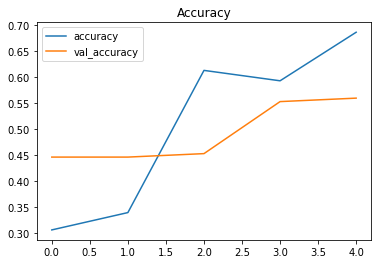

In [14]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

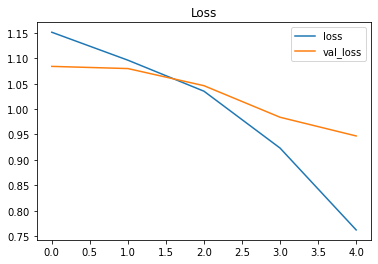

In [15]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [16]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

y_test = [labels[k] for k in test_images.classes]

In [17]:
from sklearn.metrics import accuracy_score
acc = accuracy_score(y_test, pred)
print(f'Accuracy on the test set: {100*acc:.2f}%')

Accuracy on the test set: 56.00%


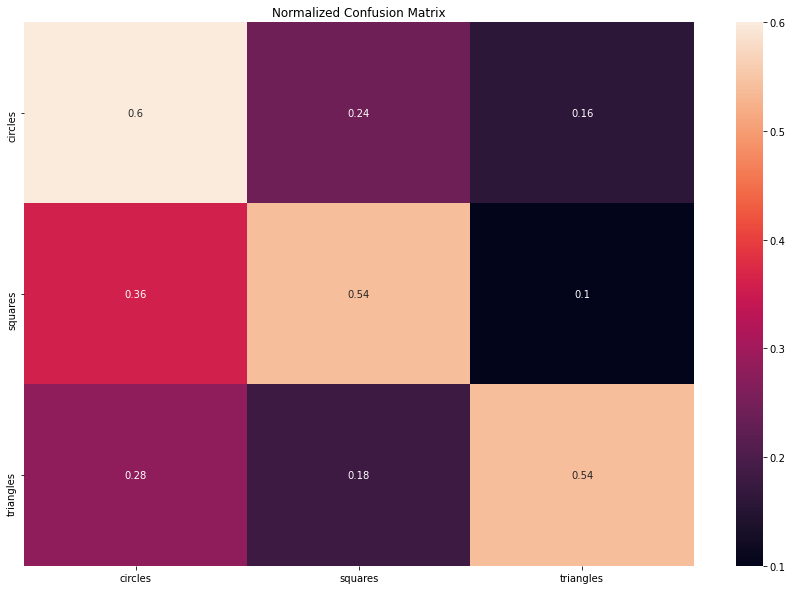

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cf_matrix = confusion_matrix(y_test, pred, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(y_test)), 
            yticklabels = sorted(set(y_test)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

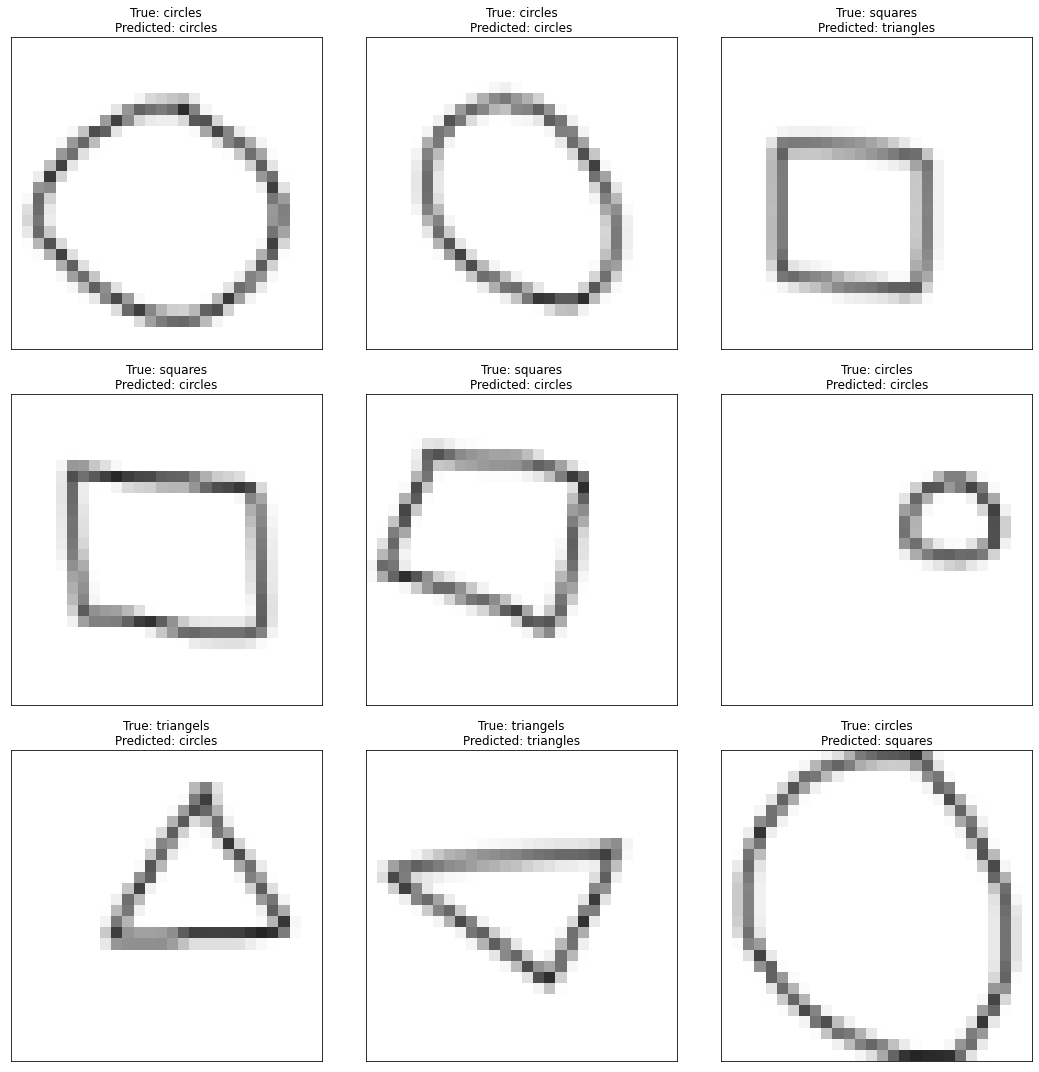

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()